In [1]:
import sys
import re
import os
import time
import random

import jieba
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import numpy as np

# import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pylab

pylab.rcParams["font.family"] = "simhei"
import cv2
from PIL import Image, ImageDraw, ImageFont
import wave

In [2]:
# 读取词表
def read_words_list(path):
    with open(path) as f:
        lines = f.readlines()

    strlist = []
    for l in lines:
        if "#" != l[0] and "" != l.strip():
            l = l.strip()
            strlist.append(l)
    return strlist


# 去除常用词
def remove_stop_words(text, stop_words):
    # 保存过滤词数量的字典
    swords_cnt = {}

    while "  " in text:  # 去掉多余空格
        text = text.replace("  ", " ")
    for key, words in stop_words.items():
        swords_cnt[key] = np.zeros(len(words))  # 创建向量
        for i, stpwd in enumerate(words):
            if (stpwd) in text:
                text = text.replace(" " + stpwd + " ", " ")
                #                 swords_cnt[key][i] += text.count(stpwd)
                swords_cnt[key][i] += 1
    return text, swords_cnt


# 查找敏感词
def check_sens_words(text, sens_words):
    ttext = text.strip()
    sw_dict = {}  # 敏感词
    for sw in sens_words:
        n = ttext.count(sw)  # 敏感词出现次数
        if n > 0:
            if not sw_dict.__contains__(sw):
                sw_dict[sw] = 0
            sw_dict[sw] += n
    return sw_dict


# 切割句子
def sentence_cut(text):
    pattern = pattern = r"\.|/|;|\?|!|。|；|！|……"
    pre_sentence = re.split(pattern, text)
    sentence = []
    section_pos = []
    max_cnt = 2
    cnt = max_cnt + 1
    for pre in pre_sentence:
        if len(pre) > 6:
            if cnt > max_cnt:
                sentence.append(pre)
                cnt = 0
            else:
                sentence[-1] += pre
                cnt += 1
            if "\n" in pre:
                sentence[-1].replace("\n", "")
                section_pos.append(len(sentence) - 1)
                cnt = max_cnt + 1
    return sentence, section_pos


# 中文比例
def str_ratio_zh(instr):
    cnt = 0
    for s in instr:
        # 中文字符范围
        if "\u4e00" <= s <= "\u9fa5":
            cnt += 1
    return cnt / len(instr)

In [3]:
# 提取ao3文章
def extract_ao3_work(html):
    soup = BeautifulSoup(html, "html.parser")
    # 提取标题
    title_h2 = soup.find("h2", attrs={"class": "title heading"})  # 找到标题
    title = title_h2.string
    title = title.strip()
    # 提取作者
    author_a = soup.find("a", attrs={"rel": "author"})
    author = author_a.string
    # 提取分级标签
    rating_dd = soup.find("dd", attrs={"class": "rating tags"})  # 找到分级标签
    rating_a = rating_dd.find("a", attrs={"class": "tag"})  # 找到对应的a标签
    rating = rating_a.string  # 获得标签文字
    # 提取警告标签
    warning_dd = soup.find("dd", attrs={"class": "warning tags"})  # 找到警告标签
    warning_a = warning_dd.find("a", attrs={"class": "tag"})  # 找到对应的a标签
    warning = warning_a.string  # 获得标签文字
    # 提取分类标签
    try:
        category_dd = soup.find("dd", attrs={"class": "category tags"})  # 找到警告标签
        category_a = category_dd.find("a", attrs={"class": "tag"})  # 找到对应的a标签
        category = category_a.string  # 获得标签文字
    except AttributeError:
        category = "None"
    # 提取同人原著
    fandom_dd = soup.find("dd", attrs={"class": "fandom tags"})  # 找到警告标签
    fandom_a = fandom_dd.find("a", attrs={"class": "tag"})  # 找到对应的a标签
    fandom = fandom_a.string  # 获得标签文字

    # 点击量
    stats_dd = soup.find("dl", attrs={"class": "stats"})
    # 提取点击量
    hits_dd = stats_dd.find("dd", attrs={"class": "hits"})  # 找到分级标签
    try:
        hits = int(hits_dd.string)
    except AttributeError:
        hits = "未知"

    # 提取发布日期
    published_dd = stats_dd.find("dd", attrs={"class": "published"})  # 找到分级标签
    date_str = published_dd.string

    # 提取字数
    words_dd = stats_dd.find("dd", attrs={"class": "words"})  # 找到分级标签
    try:
        words_cnt = int(words_dd.string)
    except AttributeError:
        words_cnt = 0

    # 提取文章
    article_div = soup.find("div", attrs={"role": "article"})  # 找到文章标签
    article_userstuff = article_div.find("div", attrs={"class": "userstuff"})
    article_str = str(article_userstuff)
    if article_userstuff is None:
        article_str = str(article_div)
    article_str = re.sub("<h[a-z\ 0-9=\"',\[\]\-\_]*[ \>\n]", "", article_str)
    article_str = re.sub("<div[a-z\ 0-9=\"',\[\]\-\_]*[ \>\n]", "", article_str)
    article_str = re.sub("<p[a-z\ 0-9=\"',\[\]\-\_]*[ \>\n]", "", article_str)
    article_str = re.sub("<br[a-z\ 0-9=\"',\[\]\-\_]*[ \>\n]", "", article_str)
    article_str = re.sub("</h[0-9]>", "", article_str)
    article_str = article_str.replace("</p>", "。")
    article_str = article_str.replace("</br>", "\n")
    article_str = article_str.replace("&nbsp;", " ")
    article_str = article_str.replace("</div>", "")
    article_str = re.sub("<b[a-z\ 0-9=\"',\[\]\-\_]*[ \>\n]", "", article_str)
    article_str = article_str.replace("<\b>", "")
    article_str = re.sub("<img[a-z\ 0-9=\"',\[\]\-\_]*[ \>\n]", "", article_str)
    article_str = article_str.replace(">  ", "")
    article_str = article_str.replace("<br", "")
    article_str = article_str.replace("<em>", "")  # 漏网
    article_str = re.sub('[a-z\ 0-9="\',\[\]\-\_]*"\>', "", article_str)

    # time.sleep(3)
    return (
        title,
        author,
        fandom,
        rating,
        warning,
        category,
        hits,
        date_str,
        words_cnt,
        article_str,
    )

In [4]:
stop_words_path = "hit_stopwords.txt"
stop_words = read_words_list(stop_words_path)
# torch专用切割
def cut_sentence(sentence):
    return [token for token in jieba.lcut(sentence) if token not in stop_words]

In [5]:
# get_dataset构造并返回Dataset所需的examples和fields
def get_test_dataset(test_data, text_field, label_field, fields):
    examples = []
    for text in test_data:
        examples.append(torchtext.data.Example.fromlist([text], fields))
    test = torchtext.data.Dataset(examples, fields)
    return test

In [6]:
class TextCNN(nn.Module):
    def __init__(
        self,
        class_num,  # 分类数
        filter_sizes,  # 卷积核的长也就是滑动窗口的长
        filter_num,  # 卷积核的数量
        vocabulary_size,  # 词表的大小
        embedding_dimension,  # 词向量的维度
        vectors,  # 词向量
        dropout,
    ):  # dropout率
        super(TextCNN, self).__init__()  # 继承nn.Module

        chanel_num = 1  # 通道数，也就是一篇文章一个样本只相当于一个feature map

        self.embedding = nn.Embedding(vocabulary_size, embedding_dimension)  # 嵌入层
        self.embedding = self.embedding.from_pretrained(vectors)  # 嵌入层加载预训练词向量

        self.convs = nn.ModuleList(
            [
                nn.Conv2d(chanel_num, filter_num, (fsz, embedding_dimension))
                for fsz in filter_sizes
            ]
        )  # 卷积层
        self.dropout = nn.Dropout(dropout)  # dropout
        self.fc = nn.Linear(len(filter_sizes) * filter_num, class_num)  # 全连接层

    def forward(self, x):
        # x维度[句子长度,一个batch中所包含的样本数] 例:[3451,128]
        x = self.embedding(
            x
        )  # #经过嵌入层之后x的维度，[句子长度,一个batch中所包含的样本数,词向量维度] 例：[3451,128,300]
        x = x.permute(
            1, 0, 2
        )  # permute函数将样本数和句子长度换一下位置，[一个batch中所包含的样本数,句子长度,词向量维度] 例：[128,3451,300]
        x = x.unsqueeze(
            1
        )  # # conv2d需要输入的是一个四维数据，所以新增一维feature map数 unsqueeze(1)表示在第一维处新增一维，[一个batch中所包含的样本数,一个样本中的feature map数，句子长度,词向量维度] 例：[128,1,3451,300]
        x = [
            conv(x) for conv in self.convs
        ]  # 与卷积核进行卷积，输出是[一个batch中所包含的样本数,卷积核数，句子长度-卷积核size+1,1]维数据,因为有[3,4,5]三张size类型的卷积核所以用列表表达式 例：[[128,16,3459,1],[128,16,3458,1],[128,16,3457,1]]
        x = [
            sub_x.squeeze(3) for sub_x in x
        ]  # squeeze(3)判断第三维是否是1，如果是则压缩，如不是则保持原样 例：[[128,16,3459],[128,16,3458],[128,16,3457]]
        x = [F.relu(sub_x) for sub_x in x]  # ReLU激活函数激活，不改变x维度
        x = [
            F.max_pool1d(sub_x, sub_x.size(2)) for sub_x in x
        ]  # 池化层，根据之前说的原理，max_pool1d要取出每一个滑动窗口生成的矩阵的最大值，因此在第二维上取最大值 例：[[128,16,1],[128,16,1],[128,16,1]]
        x = [
            sub_x.squeeze(2) for sub_x in x
        ]  # 判断第二维是否为1，若是则压缩 例：[[128,16],[128,16],[128,16]]
        x = torch.cat(x, 1)  # 进行拼接，例：[128,48]
        x = self.dropout(
            x
        )  # 去除掉一些神经元防止过拟合，注意dropout之后x的维度依旧是[128,48]，并不是说我dropout的概率是0.5，去除了一半的神经元维度就变成了[128,24]，而是把x中的一些神经元的数据根据概率全部变成了0，维度依旧是[128,48]
        logits = self.fc(x)  # 全接连层 例：输入x是[128,48] 输出logits是[128,10]
        return logits

加载模型和Field

In [7]:
text_field_path = "./word_embedding/ao3_text.field"
label_field_path = "./word_embedding/ao3_label.field"
model_path = "./model/bestmodel_steps800.pt"

In [8]:
ao3_text = torch.load(text_field_path)
ao3_label = torch.load(label_field_path)

class_num = len(ao3_label.vocab)  # 类别数目
filter_size = [3, 4, 5]  # 卷积核种类数
filter_num = 16  # 卷积核数量
vocab_size = len(ao3_text.vocab)  # 词表大小
embedding_dim = ao3_text.vocab.vectors.size()[-1]  # 词向量维度
vectors = ao3_text.vocab.vectors  # 词向量
dropout = 0.5  # (not used)
learning_rate = 0.001  # (not used) 学习率
epochs = 5  # (not used) 迭代次数
save_dir = "./model"  # 模型保存路径
steps_show = 10  # (not used) 每10步查看一次训练集loss和mini batch里的准确率
steps_eval = 200  # (not used) 每100步测试一下验证集的准确率
early_stopping = 1000  # (not used) 若发现当前验证集的准确率在1000步训练之后不再提高 一直小于best_acc,则提前停止训练

textcnn_model = TextCNN(
    class_num=class_num,
    filter_sizes=filter_size,
    filter_num=filter_num,
    vocabulary_size=vocab_size,
    embedding_dimension=embedding_dim,
    vectors=vectors,
    dropout=dropout,
)

textcnn_model.load_state_dict(torch.load(model_path))  # 加载训练好的参数

<All keys matched successfully>

文章迭代器

In [9]:
def workIterator(article_str, text_field, label_field):
    sents, section_pos = sentence_cut(article_str)
    test_dataset = get_test_dataset(
        sents, text_field, label_field, fields=[("content", ao3_text)]
    )

    test_iter = torchtext.data.Iterator(
        test_dataset,  # 需要生成迭代器的数据集
        batch_size=128,  # 每个迭代器分别以多少样本为一个batch
        train=False,
        shuffle=False,
        sort=False,
    )
    return test_iter, sents, section_pos

In [10]:
def work_eval(work_iter, model):
    model.eval()
    sorc_buf = []
    for batch in work_iter:
        feature = batch.content
        if torch.cuda.is_available():
            feature = feature.cuda()
        feature_str = ""
        #         for feat in feature:
        #             for f in feat:
        #                 feature_str += ao3_text.vocab.itos[f]
        #         print(feature_str)
        logits = model(feature)
        sorc = torch.argmax(logits, dim=1)
        sorc_buf += sorc

    return sorc_buf

## 绘图函数

In [40]:
def draw_title_author(img, title, author, pos, fandom=None):
    # PIL图片上打印汉字
    pilimg = Image.fromarray(img)
    draw = ImageDraw.Draw(pilimg)  # 图片上打印
    font = ImageFont.truetype("simhei.ttf", 14, encoding="utf-8")  # 参数1：字体文件路径，参数2：字体大小

    uline_w = 1

    # 标题 红 下划线
    twidth, theight = draw.textsize(title, font=font)
    lx, ly = pos[0], pos[1] + theight + uline_w
    draw.text(pos, title, (0, 0, 176), font=font)  # 参数1：打印坐标，参数2：文本，参数3：字体颜色，参数4：字体
    draw.line((lx, ly, lx + twidth, ly), (0, 0, 176))

    # 同人作品 黑 下虚线
    if fandom is not None:
        pos_f = pos[:]
        pos_f[1] += theight + 10
        twidth_f, theight_f = draw.textsize(fandom, font=font)
        lx, ly = pos_f[0], pos_f[1] + theight_f + uline_w
        draw.text(pos_f, fandom, (0, 0, 0), font=font)
        for xi in range(lx, lx + twidth_f, 6):
            draw.line((xi, ly, xi + 3, ly), (0, 0, 0))

    # by 黑 无下划线
    pos[0] += twidth
    twidth, theight = draw.textsize(" by ", font=font)
    draw.text(pos, " by ", (0, 0, 0), font=font)

    # 作者 红 下划线
    pos[0] += twidth
    twidth, theight = draw.textsize(author, font=font)
    lx, ly = pos[0], pos[1] + theight + uline_w
    draw.text(pos, author, (0, 0, 176), font=font)
    draw.line((lx, ly, lx + twidth, ly), (0, 0, 176))

    img = np.array(pilimg)

    return img


def draw_text(img, text, text_size, pos, maxline):
    pilimg = Image.fromarray(img)
    draw = ImageDraw.Draw(pilimg)  # 图片上打印
    font = ImageFont.truetype(
        "simhei.ttf", text_size, encoding="utf-8"
    )  # 参数1：字体文件路径，参数2：字体大小

    if len(text) > maxline:
        in_text = text[:maxline]
        out_text = text[maxline:]
    else:
        in_text = text
        out_text = None
    twidth_f, theight_f = draw.textsize(in_text, font=font)
    draw.text(pos, in_text, (0, 0, 0), font=font)
    img = np.array(pilimg)

    return img, out_text, theight_f


def make_micro_work_img(sents, logits, section_pos, words_cnt):
    img_w = 115

    img_h = max(words_cnt // 10, len(sents) * 10) + 20
    if img_h < 200:
        img_h = 200

    img = np.ones([img_h, img_w, 3], dtype=np.uint8) * 180
    cv2.rectangle(img, (0, 0), (img_w - 5, img_h - 5), (255, 255, 255), -1)
    cv2.rectangle(img, (0, 0), (img_w, 5), (255, 255, 255), -1)
    cv2.rectangle(img, (0, 0), (img_w - 5, img_h - 5), (0, 0, 0), 1, 4)

    wd_min_w = 10
    wd_max_w = img_w - 15

    wd_w_cnt = wd_min_w + 8
    wd_h_cnt = wd_min_w

    gap = 2
    if section_pos:
        section_pos_cnt = 0
    else:
        section_pos_cnt = -1

    sex_sents = []
    sex_sents_h_buf = []
    pre_sex_sent_id = -1
    non_sex_gep = 2
    gep_w = 1
    for i, (sent, log) in enumerate(zip(sents, logits)):
        if str_ratio_zh(sent) < 0.5:
            log = 0
        if 1 == log:  # 记录所在位置起始点
            sex_sent_h = [wd_h_cnt]
        # 写字
        for wd in sent:
            if 0 == log:
                cv2.rectangle(
                    img,
                    (wd_w_cnt, wd_h_cnt),
                    (wd_w_cnt + gep_w, wd_h_cnt + gap),
                    (220, 220, 220),
                    -1,
                )
            else:
                cv2.rectangle(
                    img,
                    (wd_w_cnt, wd_h_cnt - gap * 3 // 2),
                    (wd_w_cnt + gep_w, wd_h_cnt + gap * 3 // 2),
                    (0, 200, 200),
                    -1,
                )

            if wd_w_cnt < wd_max_w:
                wd_w_cnt += gep_w
            else:
                wd_w_cnt = wd_min_w
                wd_h_cnt += 5 * gap // 2
        if 1 == log:
            if wd_h_cnt != sex_sent_h[-1]:  # 记录所在位置结束点
                sex_sent_h.append(wd_h_cnt)
            # 查找覆盖范围内是否有标记语句
            if i - non_sex_gep < 0:
                sex_cover = 0
            else:
                sex_cover = i - non_sex_gep
            # 如果发现上句在范围内
            if pre_sex_sent_id >= 0 and sex_cover <= pre_sex_sent_id:
                for sexi in range(pre_sex_sent_id + 1, i):
                    sex_sents[-1] += sents[sexi]
                sex_sents[-1] += sent

                sex_sents_h_buf[-1].append(sex_sent_h[-1])
            else:  # 不在范围内则新建句子
                sex_sents.append(sent)
                sex_sents_h_buf.append(sex_sent_h)

            pre_sex_sent_id = i

        # 每句空一格
        if wd_w_cnt < wd_max_w:
            wd_w_cnt += gap
        else:
            wd_w_cnt = wd_min_w
            wd_h_cnt += 5 * gap // 2
        # 遇到段落空一行
        if section_pos_cnt >= 0 and i == section_pos[section_pos_cnt]:
            #             pre_sex_sent_id = -1 #隔断不考虑连句
            wd_w_cnt = wd_min_w + 8
            wd_h_cnt += 5 * gap // 2
            if section_pos_cnt < len(section_pos) - 1:
                section_pos_cnt += 1
            else:
                section_pos_cnt = -1
    if wd_h_cnt > 220:
        img = np.vstack((img[: wd_h_cnt + 5 * gap // 2, :, :], img[-20:, :, :]))

    return img, sex_sents, sex_sents_h_buf


def make_title_img(
    title,
    author,
    fandom,
    sents,
    logits,
    section_pos,
    rating,
    waring,
    category,
    hits,
    date_str,
    words_cnt,
):
    rating_ico_path = "./img/icos/Rating"
    relation_ico_path = "./img/icos/Relationships"
    finished_ico_path = "./img/icos/Finished"
    warings_ico_path = "./img/icos/Warnings"

    # 文章小地图加载
    micro_img, sex_sents, sex_sents_h_buf = make_micro_work_img(
        sents, logits, section_pos, words_cnt
    )

    img_w = 781
    img_h = micro_img.shape[0] + 20
    img = np.ones([img_h, img_w, 3], dtype=np.uint8) * 255

    # 画线
    # 起点和终点的坐标

    point_color = (221, 221, 221)  # BGR
    thickness = 1
    cv2.line(img, (6, 6), (img_w - 6, 6), point_color, thickness)
    cv2.line(img, (6, 6), (6, img_h - 6), point_color, thickness)
    cv2.line(img, (img_w - 6, 6), (img_w - 6, img_h - 6), point_color, thickness)
    cv2.line(img, (6, img_h - 6), (img_w - 6, img_h - 6), point_color, thickness)

    # 日期
    img, _, _ = draw_text(img, date_str, 13, [545, 20], 100)

    # 图标
    if "General" in rating:
        rating_ico = cv2.imread(os.path.join(rating_ico_path, "G.jpeg"))
    elif "Teen" in rating:
        rating_ico = cv2.imread(os.path.join(rating_ico_path, "T.png"))
    elif "Mature" in rating:
        rating_ico = cv2.imread(os.path.join(rating_ico_path, "M.jpeg"))
    elif "Explicit" in rating:
        rating_ico = cv2.imread(os.path.join(rating_ico_path, "E.png"))
    else:
        rating_ico = cv2.imread(os.path.join(rating_ico_path, "N.png"))

    if "M/M" in category:
        relation_ico = cv2.imread(os.path.join(relation_ico_path, "MM.jpg"))
    elif "F/M" in category:
        relation_ico = cv2.imread(os.path.join(relation_ico_path, "FM.jpeg"))
    elif "F/F" in category:
        relation_ico = cv2.imread(os.path.join(relation_ico_path, "FF.jpeg"))
    elif "Gen" in category:
        relation_ico = cv2.imread(os.path.join(relation_ico_path, "Gen.jpeg"))
    elif "Multi" in category:
        relation_ico = cv2.imread(os.path.join(relation_ico_path, "Multi.png"))
    else:
        relation_ico = cv2.imread(os.path.join(relation_ico_path, "Not_Category.png"))
    if words_cnt > 200:
        finished_ico = cv2.imread(os.path.join(finished_ico_path, "complete-yes.png"))
    else:
        finished_ico = cv2.imread(os.path.join(finished_ico_path, "xcomplete-no.jpg"))

    if "No Archive Warnings Apply" in waring:
        warings_ico = cv2.imread(os.path.join(warings_ico_path, "warning-no.png"))
    elif "Not To Use" in waring:
        warings_ico = cv2.imread(
            os.path.join(warings_ico_path, "xwarning-choosenotto.png")
        )
    else:
        warings_ico = cv2.imread(os.path.join(warings_ico_path, "warning-yes.png"))

    # 绘制小图标
    try:
        img[
            19 : (19 + rating_ico.shape[1]), 18 : (18 + rating_ico.shape[0]), :
        ] = rating_ico
    except ValueError as e:
        print("rating_ico")
        print(e)
        print(rating_ico.shape)
    try:
        img[
            19 : (19 + relation_ico.shape[1]), 46 : (46 + relation_ico.shape[0]), :
        ] = relation_ico
    except ValueError as e:
        print("relation_ico")
        print(e)
        print(relation_ico.shape)
    try:
        img[
            47 : (47 + warings_ico.shape[1]), 18 : (18 + warings_ico.shape[0]), :
        ] = warings_ico
    except ValueError as e:
        print("warings_ico")
        print(e)
        print(warings_ico.shape)
    try:
        img[
            47 : (47 + finished_ico.shape[1]), 46 : (46 + finished_ico.shape[0]), :
        ] = finished_ico
    except ValueError as e:
        print("finished_ico")
        print(e)
        print(finished_ico.shape)

    # 加文章标题
    img = draw_title_author(img, title, author, [82, 18], fandom)

    # 加文章小地图
    img[
        10 : micro_img.shape[0] + 10, img_w - 10 - micro_img.shape[1] : img_w - 10, :
    ] = micro_img
    # 加首页
    head = cv2.imread("./img/icos/ao3_head.png")
    # 首页加字
    info_str = "字数:{}  点击量:{}  疑似比例:{:.3}%".format(
        words_cnt, hits, logits.count(1) * 100.0 / len(logits)
    )
    head, _, _ = draw_text(head, info_str, 13, [470, 25], 100)
    ###############################################################################################
    imgs = []
    for sent, sent_h in zip(sex_sents, sex_sents_h_buf):
        if len(sent) < 60:
            continue
        sub_img = img.copy()
        # 加小地图高亮
        sub_map_h0 = sent_h[0] + 5
        sub_map_h1 = sent_h[-1] + 17
        cv2.rectangle(
            sub_img,
            (img_w - 8 - micro_img.shape[1], sub_map_h0),
            (img_w - 17, sub_map_h1),
            (0, 0, 176),
            1,
            4,
        )
        # 填写关注文字
        text_size = 14
        text_pos = [18, 80]

        sub_img, rem_text, text_h = draw_text(sub_img, sent, text_size, text_pos, 45)
        while rem_text is not None and text_pos[1] < img_h - 30:
            text_pos[1] += text_h + 2
            sub_img, rem_text, text_h = draw_text(
                sub_img, rem_text, text_size, text_pos, 45
            )

        # 加logo
        sub_img = np.vstack((head, sub_img))
        imgs.append(sub_img)

    return imgs

## 准备音乐

In [12]:
themass_path = "./img/icos/the_mass.wav"
video_framerate = 24

In [13]:
wav_file = wave.open(themass_path, "r")
# getparams() 一次性返回所有的WAV文件的格式信息
# nframes 采样点数目
numchannel = wav_file.getnchannels()  # 声道数
samplewidth = wav_file.getsampwidth()  # 量化位数
framerate = wav_file.getframerate()  # 采样频率
numframes = wav_file.getnframes()  # 采样点数

Wav_Data = wav_file.readframes(numframes - 240000)
Wav_Data = np.fromstring(Wav_Data, dtype=np.int16)
wave_data = Wav_Data * 1.0 / (max(abs(Wav_Data)))  # 对数据进行归一化

# wave_data = np.fromstring(str_data, dtype = np.short)
print("采样点数目：" + str(len(wave_data)))  # 输出应为采样点数目
print("帧率：" + str(framerate))  # 输出应为采样点数目
wav_file.close()

/home/zhiwei/miniconda3/envs/dslen/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


采样点数目：19064928
帧率：44100


In [14]:
# 计算每一帧的能量 framerate//video_framerate 个采样点为一帧


def calEnergy(wave_data, framerate, video_framerate):
    energy = []
    sum = 0
    for i in range(len(wave_data)):
        sum = sum + (wave_data[i] * wave_data[i])
        if (i + 1) % framerate * 2 // video_framerate == 0:
            energy.append(sum)
            sum = 0
        elif i == len(wave_data) - 1:
            energy.append(sum)
    return np.array(energy)

In [15]:
energy = calEnergy(wave_data, framerate, video_framerate)
energy /= np.max(energy)

# 后半段差值：
offset = 32
energy_len = len(energy)


for i in range(1670 + offset, energy_len):
    energy[i] += energy[i - offset]
    if energy[i] > 1:
        energy[i] /= 2

# vf = 256
# for e in range(vf, len(energy)):
#     emax = np.max(energy[e-vf:e])
#     energy[e-vf:e] *= energy_max/emax
# energy /= energy_max

5196
1001


<Figure size 432x288 with 0 Axes>

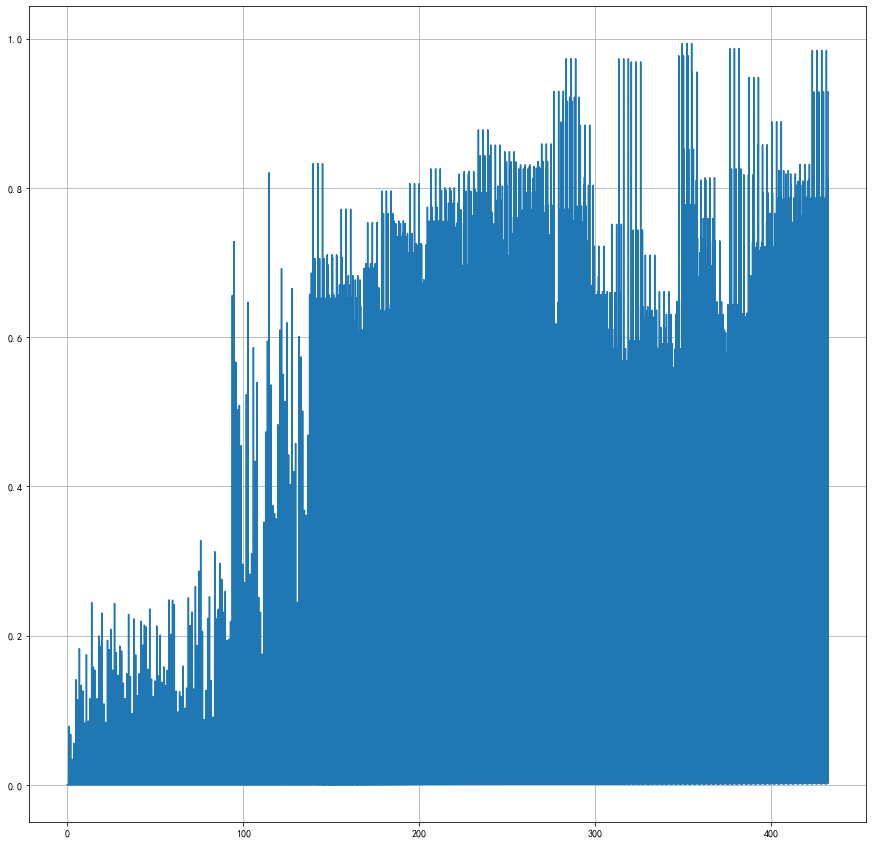

In [16]:
Time = np.linspace(0, len(wave_data) / framerate * 1.0, num=len(energy))
print(len(energy))
print(len(energy[energy > 0.1]))
plt.figure(2)
plt.figure(figsize=(15, 15))
plt.plot(Time, energy)
plt.grid(True)
plt.show()

## 开始准备资料

In [43]:
sens_words_path = "sensitive_words.txt"
sens_words = read_words_list(sens_words_path)

base_path = "lofter_works/"
base_b_path = "fulltext/"
video_path = "output2.avi"
ao3_dirlist = os.listdir(base_path)
ao3_dirlist.sort()
# print(ao3_dirlist)
ao3_pbar = tqdm(ao3_dirlist)






  0%|          | 0/1636 [00:00<?, ?it/s]

In [44]:
frame_max = len(energy)
frame_cnt = 0

# 创建VideoWriter类对象
fourcc = cv2.VideoWriter_fourcc(*"XVID")
video_w = 960
video_h = 1706
vout = cv2.VideoWriter(video_path, fourcc, video_framerate, (video_w, video_h))

frame_img = np.ones([video_h, video_w, 3], dtype=np.uint8) * 255

for work in ao3_pbar:
    if frame_cnt >= frame_max:
        break
    work_path = os.path.join(base_path, work)
    with open(work_path) as f:
        work_str = f.read()  # 读取文章

    (
        title,
        author,
        fandom,
        rating,
        warning,
        category,
        hits,
        date_str,
        words_cnt,
        article_str,
    ) = extract_ao3_work(work_str)

    work_iter, sents, section_pos = workIterator(article_str, ao3_text, ao3_label)
    logits = work_eval(work_iter, textcnn_model)

    for il in range(len(sents)):
        if 1 == logits[il]:  # 疑似
            sens = check_sens_words(sents[il], sens_words)  # 查找敏感词
            if not sens:  # 无敏感词归零
                logits[il] = 0
            else:  #####不和谐请注释######
                for ss in sens.keys():
                    sents[il] = sents[il].replace(ss, "****")
            logits[il] = 1
        else:
            logits[il] = 0

    if 0 == len(logits):
        continue
    ao3_title_imgs = make_title_img(
        title,
        author,
        fandom,
        sents,
        logits,
        section_pos,
        rating,
        warning,
        category,
        hits,
        date_str,
        words_cnt,
    )
    # 计算一个未知
    if ao3_title_imgs:
        imgwh = ao3_title_imgs[0].shape
        max_h = video_h - imgwh[0] - 2
        if max_h < 3:
            max_h = 3
        max_w = video_w - imgwh[1] - 2
        f_pos = [random.randint(2, max_h), random.randint(2, max_w)]
        imgf_gep = 3
        if len(ao3_title_imgs) > imgf_gep:  # 多于5条抽取5条
            ao3_title_imgs = ao3_title_imgs[:: len(ao3_title_imgs) // imgf_gep]
        for subimg in ao3_title_imgs:
            if subimg.shape[0] > video_h - 10:
                subimg = subimg[: video_h - 10, :, :]
                imgwh = subimg.shape

            if frame_cnt >= frame_max:
                break
            erh = 100 - int(energy[frame_cnt] * 100)
            while frame_cnt < frame_max and 95 < erh:
                # 绘制能量图
                frame_img = cv2.rectangle(
                    frame_img, (video_w - 5, 0), (video_w, 100), (255, 255, 255), -1
                )
                frame_img = cv2.rectangle(
                    frame_img, (video_w - 5, erh), (video_w, 100), (220, 0, 0), -1
                )
                vout.write(frame_img)

                erh = 100 - int(energy[frame_cnt] * 100)
                frame_cnt += 1

            frame_img = cv2.GaussianBlur(frame_img, (17, 17), 1.5)
            # 绘制能量图
            frame_img = cv2.rectangle(
                frame_img, (video_w - 5, 0), (video_w, 100), (255, 255, 255), -1
            )
            frame_img = cv2.rectangle(
                frame_img, (video_w - 5, erh), (video_w, 100), (220, 0, 0), -1
            )
            frame_img[
                f_pos[0] : f_pos[0] + imgwh[0], f_pos[1] : f_pos[1] + imgwh[1], :
            ] = subimg
            vout.write(frame_img)
            frame_cnt += 1
    #         plt.figure(figsize=(15,15))
    #         plt.imshow(frame_img[:,:,::-1])
    #         plt.show(rating)

vout.release()






  0%|          | 1/1636 [00:02<1:17:02,  2.83s/it]




  0%|          | 2/1636 [00:03<59:57,  2.20s/it]  




  0%|          | 3/1636 [00:04<47:44,  1.75s/it]




  0%|          | 4/1636 [00:04<38:34,  1.42s/it]




  0%|          | 5/1636 [00:05<32:00,  1.18s/it]




  0%|          | 6/1636 [00:06<30:08,  1.11s/it]




  0%|          | 7/1636 [00:07<28:42,  1.06s/it]




  0%|          | 8/1636 [00:08<26:29,  1.02it/s]




  1%|          | 9/1636 [00:09<26:00,  1.04it/s]




  1%|          | 10/1636 [00:10<25:20,  1.07it/s]




  1%|          | 11/1636 [00:10<24:19,  1.11it/s]




  1%|          | 12/1636 [00:11<25:32,  1.06it/s]




  1%|          | 13/1636 [00:12<23:35,  1.15it/s]




  1%|          | 14/1636 [00:12<17:56,  1.51it/s]




  1%|          | 15/1636 [00:12<14:04,  1.92it/s]




  1%|          | 16/1636 [00:14<20:37,  1.31it/s]




  1%|          | 17/1636 [00:15<24:47,  1.09it/s]




  1%|          | 18/1636 [00:16<25:02,  1.08it/s]




  1%|          | 19/1636 [00